## SSCN이란?
- 3D 공간의 대부분은 빈 영역입니다. Dense 3D CNN은 비어있는 격자에도 연산을 수행하여 비효율적입니다.
- Sparse Convolution은 "활성(voxel이 존재하는) 좌표"에 대해서만 연산합니다.
- Submanifold Sparse Convolution(SubMConv)은 활성 좌표 집합을 그대로 유지하면서, 주변 이웃의 정보를 모읍니다(새 좌표를 만들지 않음).
- Strided Sparse Convolution은 해상도를 낮추고(다운샘플링), Transposed(Sparse Deconv)는 해상도를 올립니다(업샘플링).
- SSCN U-Net은 이러한 연산을 계층적으로 쌓아, 효율적으로 3D 의미 분할을 수행합니다.

In [2]:
#@title Backend and quick options
BACKEND = "DENSE"  #@param ["ME", "DENSE"] {type:"string"}
USE_SYNTHETIC = True  #@param {type:"boolean"}
VOXEL_SIZE = 0.05  #@param {type:"number"}  # meters per voxel
NUM_CLASSES = 6    # 0:floor,1:ceiling,2:wall,3:table,4:chair,5:clutter

# Training hyperparameters (small for demo)
MAX_EPOCHS = 3     #@param {type:"integer"}
BATCH_SIZE = 2     #@param {type:"integer"}
LR = 1e-3          #@param {type:"number"}
SEED = 42          #@param {type:"integer"}
DEVICE_OVERRIDE = ""  # e.g., "cpu" to force CPU; empty for auto

BACKEND: "ME" 또는 "DENSE"

USE_SYNTHETIC: 데모용 합성 3D 실내 데이터 사용 여부

학습 하이퍼파라미터 기본값 설정

In [3]:
#@title Install dependencies
import os, sys, subprocess

def pip_install(pkgs, extra_args=None):
    cmd = [sys.executable, "-m", "pip", "install", "-U"] + list(pkgs) + (extra_args or [])
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)

# Base stack
pip_install(["numpy", "scipy", "scikit-learn", "tqdm", "matplotlib"])

# Optional: open3d (시각화용, 여기서는 사용하지 않아 설치 생략 가능)
# pip_install(["open3d"])

# If needed, pin torch to a specific CUDA (Colab은 기본 제공)
# pip_install(["torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cu121"])

if BACKEND == "ME":
    pip_install(["ninja", "cmake"])
    try:
        pip_install(["git+https://github.com/NVIDIA/MinkowskiEngine"], extra_args=["-v"])
    except Exception:
        print("MinkowskiEngine GPU build failed. Retrying CPU-only build...")
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        pip_install(["git+https://github.com/NVIDIA/MinkowskiEngine"], extra_args=["-v"])

Running: /usr/bin/python3 -m pip install -U numpy scipy scikit-learn tqdm matplotlib


ME: MinkowskiEngine(진짜 submanifold sparse 연산)

DENSE: 마스크 기반의 Dense 3D UNet(서브매니폴드 동작을 근사). 설치 간편, 어디서나 동작.

In [4]:
#@title Imports and configuration
import math
import time
import random
import numpy as np
from typing import Tuple, List, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(SEED)

def get_device():
    if DEVICE_OVERRIDE.strip():
        return torch.device(DEVICE_OVERRIDE.strip())
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
print("Device:", device)

if BACKEND == "ME":
    try:
        import MinkowskiEngine as ME
        print("MinkowskiEngine version:", getattr(ME, "__version__", "unknown"))
    except Exception as e:
        raise RuntimeError("Requested BACKEND='ME' but MinkowskiEngine is not importable. Re-run installs or set BACKEND='DENSE'.") from e

Device: cuda


ME 선택 시 MinkowskiEngine 임포트 확인

In [5]:
#@title Synthetic dataset: Rooms
class SyntheticRooms3D(Dataset):
    def __init__(self, n_scenes=60, n_points=20000, num_classes=6, seed=SEED):
        super().__init__()
        self.n_scenes = n_scenes
        self.n_points = n_points
        self.num_classes = num_classes
        self.rng = np.random.RandomState(seed)

    def __len__(self):
        return self.n_scenes

    def _random_room(self):
        N = self.n_points
        pts = self.rng.rand(N, 3)
        pts[:, 0] *= 5.0
        pts[:, 1] *= 5.0
        pts[:, 2] *= 3.0

        colors = np.zeros((N, 3), dtype=np.float32)
        labels = np.full((N,), 5, dtype=np.int64)  # clutter

        floor_mask = (pts[:, 2] < 0.15)
        labels[floor_mask] = 0
        colors[floor_mask] = np.array([0.7, 0.7, 0.7])

        ceil_mask = (pts[:, 2] > 2.85)
        labels[ceil_mask] = 1
        colors[ceil_mask] = np.array([1.0, 1.0, 1.0])

        wall_mask = (pts[:,0] < 0.15) | (pts[:,0] > 4.85) | (pts[:,1] < 0.15) | (pts[:,1] > 4.85)
        labels[wall_mask] = 2
        colors[wall_mask] = np.array([0.9, 0.9, 0.9])

        table_center = np.array([2.5, 2.5, 0.75])
        table_size = np.array([1.2, 0.8, 0.1])
        table_mask = (
            (np.abs(pts[:,0]-table_center[0]) < table_size[0]) &
            (np.abs(pts[:,1]-table_center[1]) < table_size[1]) &
            (np.abs(pts[:,2]-table_center[2]) < table_size[2])
        )
        labels[table_mask] = 3
        colors[table_mask] = np.array([0.8, 0.4, 0.1])

        chair_center = np.array([3.4, 2.2, 0.45])
        chair_size = np.array([0.3, 0.3, 0.25])
        chair_mask = (
            (np.abs(pts[:,0]-chair_center[0]) < chair_size[0]) &
            (np.abs(pts[:,1]-chair_center[1]) < chair_size[1]) &
            (np.abs(pts[:,2]-chair_center[2]) < chair_size[2])
        )
        labels[chair_mask] = 4
        colors[chair_mask] = np.array([0.2, 0.6, 0.9])

        clutter_mask = (labels == 5)
        colors[clutter_mask, 0] = 0.1 + 0.6 * (pts[clutter_mask,2] / 3.0)
        colors[clutter_mask, 1] = 0.2
        colors[clutter_mask, 2] = 0.3

        order = self.rng.permutation(N)
        pts = pts[order].astype(np.float32)
        colors = colors[order].astype(np.float32)
        labels = labels[order].astype(np.int64)

        return pts, colors, labels

    def __getitem__(self, idx):
        return self._random_room()

def make_splits(n_total, val_ratio=0.2, seed=SEED):
    idxs = list(range(n_total))
    rng = random.Random(seed)
    rng.shuffle(idxs)
    n_val = int(n_total * val_ratio)
    return idxs[n_val:], idxs[:n_val]

간단한 룸 구조(바닥/천장/벽/테이블/의자/잡동사니) 생성

In [6]:
#@title Voxelization and collation
def voxelize_points(points, feats, labels, voxel_size: float):
    coords = np.floor(points / voxel_size).astype(np.int64)
    keys, inv, counts = np.unique(coords, axis=0, return_inverse=True, return_counts=True)

    C = feats.shape[1]
    feats_sum = np.zeros((keys.shape[0], C), dtype=np.float64)
    np.add.at(feats_sum, inv, feats)
    feats_agg = (feats_sum / counts[:, None]).astype(np.float32)

    labels_agg = np.zeros((keys.shape[0],), dtype=np.int64)
    for k in range(keys.shape[0]):
        mask = (inv == k)
        lbls = labels[mask]
        vals, freqs = np.unique(lbls, return_counts=True)
        labels_agg[k] = vals[np.argmax(freqs)]

    return keys.astype(np.int32), feats_agg, labels_agg

def collate_sparse(samples, voxel_size):
    if BACKEND == "ME":
        coords_batch, feats_batch, labels_batch = [], [], []
        for b, (pts, feats, labels) in enumerate(samples):
            c, f, y = voxelize_points(pts, feats, labels, voxel_size)
            bcol = np.full((c.shape[0],1), b, dtype=np.int32)
            coords_batch.append(np.hstack([bcol, c]))
            feats_batch.append(f)
            labels_batch.append(y)
        coords = torch.from_numpy(np.concatenate(coords_batch, 0)).int()  # keep on CPU for ME
        feats = torch.from_numpy(np.concatenate(feats_batch, 0)).float()
        labels = torch.from_numpy(np.concatenate(labels_batch, 0)).long()
        return {"coords": coords, "feats": feats, "labels": labels}
    else:
        coords_list, feats_list, labels_list = [], [], []
        mins, maxs = [], []
        for (pts, feats, labels) in samples:
            c, f, y = voxelize_points(pts, feats, labels, voxel_size)
            coords_list.append(c)
            feats_list.append(f)
            labels_list.append(y)
            mins.append(c.min(axis=0))
            maxs.append(c.max(axis=0))
        min_all = np.stack(mins,0).min(0)
        max_all = np.stack(maxs,0).max(0)
        Dx, Dy, Dz = (max_all - min_all + 1).tolist()

        C = feats_list[0].shape[1]
        dense = torch.zeros((len(samples), C, Dx, Dy, Dz), dtype=torch.float32)
        mask  = torch.zeros((len(samples), 1, Dx, Dy, Dz), dtype=torch.bool)
        labels_dense = torch.full((len(samples), Dx, Dy, Dz), fill_value=-1, dtype=torch.long)

        for b, (c, f, y) in enumerate(zip(coords_list, feats_list, labels_list)):
            c_off = c - min_all[None, :]
            x_t = torch.from_numpy(c_off[:,0]).long()
            y_t = torch.from_numpy(c_off[:,1]).long()
            z_t = torch.from_numpy(c_off[:,2]).long()
            f_t = torch.from_numpy(f).float()     # (M, C)
            lbl_t = torch.from_numpy(y).long()    # (M,)
            dense[b, :, x_t, y_t, z_t] = f_t.T    # place features
            mask[b, 0, x_t, y_t, z_t] = True
            labels_dense[b, x_t, y_t, z_t] = lbl_t

        return {"dense": dense, "mask": mask, "labels_dense": labels_dense}

def make_loader(dataset, voxel_size, batch_size=2, shuffle=True, num_workers=0):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
                      collate_fn=lambda batch: collate_sparse(batch, voxel_size))

점들을 Voxel grid에 모으고, 피처 평균/라벨 다수결

ME용 배치/ DENSE용 Dense 텐서와 마스크 생성

주의: 파이토치 고급 인덱싱에 numpy 인덱스는 사용할 수 없으므로 torch.LongTensor로 변환

In [11]:
#@title Models: ME UNet and Dense masked UNet
class ConfusionMeter:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = np.zeros((num_classes, num_classes), dtype=np.int64)
    def add(self, pred, target, ignore_index=-1):
        mask = target != ignore_index
        p = pred[mask].cpu().numpy().ravel()
        t = target[mask].cpu().numpy().ravel()
        for i in range(self.num_classes):
            for j in range(self.num_classes):
                self.mat[i, j] += np.sum((t == i) & (p == j))
    def iou(self):
        iou = []
        for i in range(self.num_classes):
            tp = self.mat[i, i]
            fp = self.mat[:, i].sum() - tp
            fn = self.mat[i, :].sum() - tp
            denom = tp + fp + fn
            iou.append(tp / denom if denom > 0 else 0.0)
        return iou, float(np.mean([v for v in iou if v == v]))

if BACKEND == "ME":
    class ME_SubMBlock(nn.Module):
        def __init__(self, in_ch, out_ch, D=3):
            super().__init__()
            self.net = nn.Sequential(
                ME.MinkowskiSubmanifoldConvolution(in_ch, out_ch, kernel_size=3, dimension=D),
                ME.MinkowskiBatchNorm(out_ch),
                ME.MinkowskiReLU(inplace=True),
                ME.MinkowskiSubmanifoldConvolution(out_ch, out_ch, kernel_size=3, dimension=D),
                ME.MinkowskiBatchNorm(out_ch),
                ME.MinkowskiReLU(inplace=True),
            )
        def forward(self, x): return self.net(x)

    class ME_UNetSmall(nn.Module):
        def __init__(self, in_ch=3, out_ch=NUM_CLASSES, D=3):
            super().__init__()
            cs = [32, 64, 128, 256]
            self.enc1 = ME_SubMBlock(in_ch, cs[0], D)
            self.down1 = ME.MinkowskiConvolution(cs[0], cs[1], kernel_size=2, stride=2, dimension=D)
            self.enc2 = ME_SubMBlock(cs[1], cs[1], D)
            self.down2 = ME.MinkowskiConvolution(cs[1], cs[2], kernel_size=2, stride=2, dimension=D)
            self.enc3 = ME_SubMBlock(cs[2], cs[2], D)
            self.down3 = ME.MinkowskiConvolution(cs[2], cs[3], kernel_size=2, stride=2, dimension=D)
            self.bott = ME_SubMBlock(cs[3], cs[3], D)
            self.up3 = ME.MinkowskiConvolutionTranspose(cs[3], cs[2], kernel_size=2, stride=2, dimension=D)
            self.dec3 = ME_SubMBlock(cs[2]+cs[2], cs[2], D)
            self.up2 = ME.MinkowskiConvolutionTranspose(cs[2], cs[1], kernel_size=2, stride=2, dimension=D)
            self.dec2 = ME_SubMBlock(cs[1]+cs[1], cs[1], D)
            self.up1 = ME.MinkowskiConvolutionTranspose(cs[1], cs[0], kernel_size=2, stride=2, dimension=D)
            self.dec1 = ME_SubMBlock(cs[0]+cs[0], cs[0], D)
            self.classifier = ME.MinkowskiConvolution(cs[0], out_ch, kernel_size=1, stride=1, dimension=D)

        def forward(self, x):
            e1 = self.enc1(x)
            e2 = self.enc2(self.down1(e1))
            e3 = self.enc3(self.down2(e2))
            b  = self.bott(self.down3(e3))
            d3 = self.up3(b); d3 = ME.cat(d3, e3); d3 = self.dec3(d3)
            d2 = self.up2(d3); d2 = ME.cat(d2, e2); d2 = self.dec2(d2)
            d1 = self.up1(d2); d1 = ME.cat(d1, e1); d1 = self.dec1(d1)
            return self.classifier(d1)

# Replace DenseUNetSmall with alignment to fix size mismatch on skip connections
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedSubMBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x, mask):
        x = self.relu(self.bn1(self.conv1(x)))
        x = x * mask
        x = self.relu(self.bn2(self.conv2(x)))
        x = x * mask
        return x

class DenseUNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=NUM_CLASSES):
        super().__init__()
        cs = [32, 64, 128, 256]
        self.enc1 = MaskedSubMBlock(in_ch, cs[0])
        self.down1 = nn.Conv3d(cs[0], cs[1], 2, stride=2)
        self.enc2 = MaskedSubMBlock(cs[1], cs[1])
        self.down2 = nn.Conv3d(cs[1], cs[2], 2, stride=2)
        self.enc3 = MaskedSubMBlock(cs[2], cs[2])
        self.down3 = nn.Conv3d(cs[2], cs[3], 2, stride=2)
        self.bott = MaskedSubMBlock(cs[3], cs[3])

        self.up3 = nn.ConvTranspose3d(cs[3], cs[2], 2, stride=2)
        self.dec3 = MaskedSubMBlock(cs[2]+cs[2], cs[2])
        self.up2 = nn.ConvTranspose3d(cs[2], cs[1], 2, stride=2)
        self.dec2 = MaskedSubMBlock(cs[1]+cs[1], cs[1])
        self.up1 = nn.ConvTranspose3d(cs[1], cs[0], 2, stride=2)
        self.dec1 = MaskedSubMBlock(cs[0]+cs[0], cs[0])

        self.classifier = nn.Conv3d(cs[0], out_ch, 1)

    @staticmethod
    def downsample_mask(mask):
        return F.max_pool3d(mask.float(), 2, stride=2).bool()

    @staticmethod
    def _align3d(x, ref_spatial):
        # x: (B,C,Dx,Dy,Dz) -> align to ref_spatial (Dr, Dy, Dz)
        if x.shape[-3:] == ref_spatial:
            return x
        # Trilinear keeps it smooth; masks are kept separately at encoder resolutions
        return F.interpolate(x, size=ref_spatial, mode='trilinear', align_corners=False)

    def forward(self, x, mask):
        # Encoder
        e1 = self.enc1(x, mask)
        m2 = self.downsample_mask(mask)

        e2 = self.enc2(self.down1(e1), m2)
        m3 = self.downsample_mask(m2)

        e3 = self.enc3(self.down2(e2), m3)
        m4 = self.downsample_mask(m3)

        b  = self.bott(self.down3(e3), m4)

        # Decoder with alignment before concatenation
        d3 = self.up3(b)
        d3 = self._align3d(d3, e3.shape[-3:])
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3, m3)

        d2 = self.up2(d3)
        d2 = self._align3d(d2, e2.shape[-3:])
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2, m2)

        d1 = self.up1(d2)
        d1 = self._align3d(d1, e1.shape[-3:])
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1, mask)

        return self.classifier(d1)

# RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 24 but got size 25 for tensor number 1 in the list.
# DENSE 백엔드의 UNet에서 업샘플 출력과 인코더 스킵 텐서(e1/e2/e3)의 공간 크기가 1칸씩 어긋날 때가 있습니다.
# Voxel Grid의 공간 크기가 2로 나누어 떨어지지 않는(홀수) 축이 있으면, stride=2 다운샘플과 ConvTranspose3d 업샘플의 조합으로 공간 크기가 정확히 되돌아오지 않아 concat 시 크기 불일치가 발생합니다.
# 에러 메시지 “Expected size 24 but got size 25”는 바로 이 “한 칸 차이” 때문에 발생한 것입니다.
# class MaskedSubMBlock(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
#         self.bn1 = nn.BatchNorm3d(out_ch)
#         self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
#         self.bn2 = nn.BatchNorm3d(out_ch)
#         self.relu = nn.ReLU(inplace=True)
#     def forward(self, x, mask):
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = x * mask
#         x = self.relu(self.bn2(self.conv2(x)))
#         x = x * mask
#         return x

# class DenseUNetSmall(nn.Module):
#     def __init__(self, in_ch=3, out_ch=NUM_CLASSES):
#         super().__init__()
#         cs = [32, 64, 128, 256]
#         self.enc1 = MaskedSubMBlock(in_ch, cs[0])
#         self.down1 = nn.Conv3d(cs[0], cs[1], 2, stride=2)
#         self.enc2 = MaskedSubMBlock(cs[1], cs[1])
#         self.down2 = nn.Conv3d(cs[1], cs[2], 2, stride=2)
#         self.enc3 = MaskedSubMBlock(cs[2], cs[2])
#         self.down3 = nn.Conv3d(cs[2], cs[3], 2, stride=2)
#         self.bott = MaskedSubMBlock(cs[3], cs[3])
#         self.up3 = nn.ConvTranspose3d(cs[3], cs[2], 2, stride=2)
#         self.dec3 = MaskedSubMBlock(cs[2]+cs[2], cs[2])
#         self.up2 = nn.ConvTranspose3d(cs[2], cs[1], 2, stride=2)
#         self.dec2 = MaskedSubMBlock(cs[1]+cs[1], cs[1])
#         self.up1 = nn.ConvTranspose3d(cs[1], cs[0], 2, stride=2)
#         self.dec1 = MaskedSubMBlock(cs[0]+cs[0], cs[0])
#         self.classifier = nn.Conv3d(cs[0], out_ch, 1)

#     def downsample_mask(mask):
#         return F.max_pool3d(mask.float(), 2, stride=2).bool()

#     def forward(self, x, mask):
#         e1 = self.enc1(x, mask)
#         m2 = self.downsample_mask(mask)
#         e2 = self.enc2(self.down1(e1), m2)
#         m3 = self.downsample_mask(m2)
#         e3 = self.enc3(self.down2(e2), m3)
#         m4 = self.downsample_mask(m3)
#         b  = self.bott(self.down3(e3), m4)

#         d3 = self.up3(b); d3 = torch.cat([d3, e3], dim=1); d3 = self.dec3(d3, m3)
#         d2 = self.up2(d3); d2 = torch.cat([d2, e2], dim=1); d2 = self.dec2(d2, m2)
#         d1 = self.up1(d2); d1 = torch.cat([d1, e1], dim=1); d1 = self.dec1(d1, mask)
#         return self.classifier(d1)

ME: SubmanifoldConv 기반 UNet

DENSE: 마스크 곱으로 활성 Voxel만 업데이트하는 SubM 근사 블록

In [8]:
#@title Train and eval loops
def train_one_epoch(model, loader, optimizer, voxel_size, num_classes, device):
    model.train()
    ce = nn.CrossEntropyLoss(ignore_index=-1)
    total_loss, total_seen = 0.0, 0
    pbar = tqdm(loader, desc="Train", leave=False)
    for batch in pbar:
        optimizer.zero_grad()
        if BACKEND == "ME":
            coords = batch["coords"]             # keep CPU for ME
            feats  = batch["feats"].to(device)
            labels = batch["labels"].to(device)
            st = ME.SparseTensor(feats, coordinates=coords, device=device)
            out = model(st)
            loss = ce(out.F, labels)
        else:
            dense = batch["dense"].to(device)
            mask  = batch["mask"].to(device)
            labels_dense = batch["labels_dense"].to(device)
            logits = model(dense, mask)
            loss = ce(logits.permute(0,2,3,4,1)[mask.squeeze(1)], labels_dense[mask.squeeze(1)])

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_seen += 1
        pbar.set_postfix(loss=f"{total_loss/total_seen:.4f}")
    return total_loss / max(total_seen, 1)

@torch.no_grad()
def evaluate(model, loader, voxel_size, num_classes, device):
    model.eval()
    meter = ConfusionMeter(num_classes)
    pbar = tqdm(loader, desc="Eval", leave=False)
    for batch in pbar:
        if BACKEND == "ME":
            coords = batch["coords"]             # keep CPU
            feats  = batch["feats"].to(device)
            labels = batch["labels"].to(device)
            st = ME.SparseTensor(feats, coordinates=coords, device=device)
            out = model(st)
            pred = out.F.argmax(dim=1)
            meter.add(pred, labels)
        else:
            dense = batch["dense"].to(device)
            mask  = batch["mask"].to(device)
            labels_dense = batch["labels_dense"].to(device)
            logits = model(dense, mask)
            pred_dense = logits.argmax(dim=1)
            meter.add(pred_dense[mask.squeeze(1)], labels_dense[mask.squeeze(1)])
    iou_per_class, miou = meter.iou()
    return iou_per_class, miou

CrossEntropyLoss(+ ignore_index=-1)

mIoU 계산

In [9]:
#@title Build datasets and loaders
if USE_SYNTHETIC:
    full = SyntheticRooms3D(n_scenes=80, n_points=20000, num_classes=NUM_CLASSES, seed=SEED)
    train_idx, val_idx = make_splits(len(full), val_ratio=0.2, seed=SEED)
    train_ds = torch.utils.data.Subset(full, train_idx)
    val_ds   = torch.utils.data.Subset(full, val_idx)
else:
    raise NotImplementedError("Set USE_SYNTHETIC=True or implement your dataset loader.")

train_loader = make_loader(train_ds, VOXEL_SIZE, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = make_loader(val_ds,   VOXEL_SIZE, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print("Batches:", len(train_loader), len(val_loader))

Batches: 32 8


기본: 합성 데이터

실제 데이터로 교체 가능

In [12]:
#@title Initialize model and train
if BACKEND == "ME":
    model = ME_UNetSmall(in_ch=3, out_ch=NUM_CLASSES).to(device)
else:
    model = DenseUNetSmall(in_ch=3, out_ch=NUM_CLASSES).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-2)

best_miou = 0.0
best_state = None

for epoch in range(1, MAX_EPOCHS+1):
    print(f"\nEpoch {epoch}/{MAX_EPOCHS}")
    tr_loss = train_one_epoch(model, train_loader, optimizer, VOXEL_SIZE, NUM_CLASSES, device)
    iou_per_cls, miou = evaluate(model, val_loader, VOXEL_SIZE, NUM_CLASSES, device)
    print(f"Train loss: {tr_loss:.4f} | Val mIoU: {miou:.4f} | IoU per class: {np.round(iou_per_cls, 3)}")
    if miou > best_miou:
        best_miou = miou
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

print(f"\nBest Val mIoU: {best_miou:.4f}")
if best_state is not None:
    model.load_state_dict(best_state)


Epoch 1/3


Train loss: 0.6038 | Val mIoU: 0.1372 | IoU per class: [0.    0.    0.019 0.    0.    0.804]

Epoch 2/3


Train loss: 0.1307 | Val mIoU: 0.6380 | IoU per class: [0.946 0.952 0.881 0.074 0.    0.975]

Epoch 3/3


Train loss: 0.0208 | Val mIoU: 0.8731 | IoU per class: [0.967 0.956 0.979 0.956 0.38  1.   ]

Best Val mIoU: 0.8731


가장 높은 mIoU의 가중치 저장

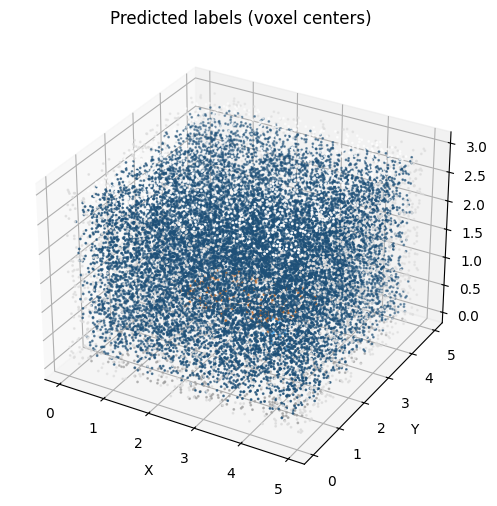

In [13]:
#@title Visualization of one validation sample
label_colors = np.array([
    [160,160,160],  # 0 floor
    [255,255,255],  # 1 ceiling
    [220,220,220],  # 2 wall
    [204,102, 26],  # 3 table
    [ 51,153,230],  # 4 chair
    [ 30, 80,120],  # 5 clutter
], dtype=np.uint8)

def visualize_sample(sample, model, voxel_size, backend=BACKEND):
    model.eval()
    pts, feats, labels = sample
    c, f, y = voxelize_points(pts, feats, labels, voxel_size)
    centers = (c.astype(np.float32) + 0.5) * voxel_size

    if backend == "ME":
        coords = torch.from_numpy(np.hstack([np.zeros((c.shape[0],1), dtype=np.int32), c.astype(np.int32)])).int()
        feats_t = torch.from_numpy(f).float()
        with torch.no_grad():
            out = model(ME.SparseTensor(feats_t.to(device), coordinates=coords, device=device))
            pred = out.F.cpu().argmax(dim=1).numpy()
    else:
        min_c = c.min(0)
        c_off = c - min_c
        Dx, Dy, Dz = (c_off.max(0)+1).tolist()
        dense = torch.zeros((1, f.shape[1], Dx, Dy, Dz), dtype=torch.float32)
        mask  = torch.zeros((1, 1, Dx, Dy, Dz), dtype=torch.bool)

        x_t = torch.from_numpy(c_off[:,0]).long()
        y_t = torch.from_numpy(c_off[:,1]).long()
        z_t = torch.from_numpy(c_off[:,2]).long()
        dense[0, :, x_t, y_t, z_t] = torch.from_numpy(f).float().T
        mask[0, 0, x_t, y_t, z_t] = True

        with torch.no_grad():
            logits = model(dense.to(device), mask.to(device))
            pred_dense = logits.argmax(dim=1).cpu().numpy()[0]
        pred = pred_dense[c_off[:,0], c_off[:,1], c_off[:,2]]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    col = label_colors[pred] / 255.0
    ax.scatter(centers[:,0], centers[:,1], centers[:,2], c=col, s=1)
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    ax.set_title("Predicted labels (voxel centers)")
    plt.show()

sample = val_ds[random.randrange(len(val_ds))] if isinstance(val_ds, torch.utils.data.Subset) else val_ds[0]
visualize_sample(sample, model, VOXEL_SIZE, BACKEND)

In [14]:
#@title Save / Load checkpoint
CKPT = "sscn_demo.pth"
torch.save({"state_dict": model.state_dict(),
            "backend": BACKEND,
            "num_classes": NUM_CLASSES,
            "voxel_size": VOXEL_SIZE}, CKPT)
print(f"Saved to {CKPT}")

ckpt = torch.load(CKPT, map_location="cpu")
print("Loaded checkpoint keys:", list(ckpt.keys()))

Saved to sscn_demo.pth
Loaded checkpoint keys: ['state_dict', 'backend', 'num_classes', 'voxel_size']


추후 재사용 및 배포를 위해 간단 저장 형식

SparseConvNet의 3D 세그멘테이션 예제는 Voxel 화된 입력, SubmanifoldConv 블록, U-Net 인코더-디코더, class-weighted CE, mIoU 평가를 사용합니다.

본 노트북의 ME 백엔드는 MinkowskiSubmanifoldConvolution/Convolution(Stride)/ConvolutionTranspose를 사용하여 동일한 개념을 현대 PyTorch 환경에서 구현합니다.

DENSE 백엔드는 마스크를 곱해 활성 Voxel 만 업데이트하는 방식으로 Submanifold 동작을 근사하여, 별도 빌드 없이 빠르게 실습할 수 있도록 했습니다.

실제 대규모 데이터셋에서는 ME 백엔드를 권장합니다. VOXEL_SIZE, 네트워크 폭, 데이터 증강, class weight 등을 조정하면 성능을 향상시킬 수 있습니다.

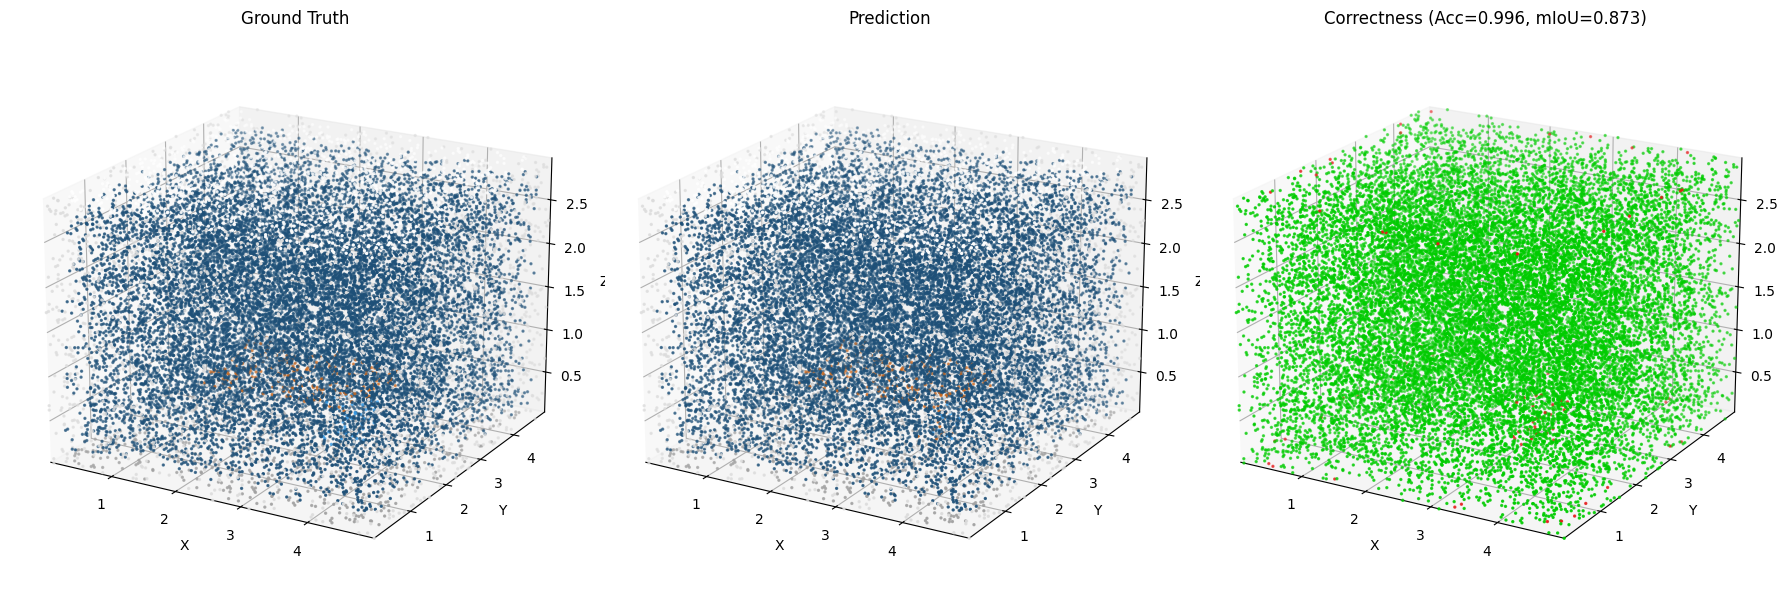

Per-class IoU:
  class 0: 0.965
  class 1: 0.961
  class 2: 0.979
  class 3: 0.930
  class 4: 0.400
  class 5: 1.000
mIoU: 0.873, Acc: 0.996


In [15]:
#@title GT vs Pred 시각화 (3D) + 샘플별 IoU/Accuracy 출력
import numpy as np
import torch
import matplotlib.pyplot as plt

# 동적 라벨 팔레트 구성 (기존 label_colors가 없거나 크기가 안 맞으면 자동 생성)
def _get_label_colors(num_classes):
    try:
        lc = label_colors
        assert isinstance(lc, np.ndarray) and lc.shape[0] >= num_classes
        return lc[:num_classes]
    except Exception:
        rng = np.random.RandomState(0)
        cols = (rng.rand(num_classes, 3) * 255).astype(np.uint8)
        return cols

def _voxelize(points, feats, labels, voxel_size):
    # 기존 voxelize_points 사용
    return voxelize_points(points, feats, labels, voxel_size)

@torch.no_grad()
def _predict_on_voxels(c, f, backend="DENSE"):
    if backend == "ME":
        coords = torch.from_numpy(np.hstack([np.zeros((c.shape[0],1), dtype=np.int32), c.astype(np.int32)])).int()
        feats_t = torch.from_numpy(f).float()
        out = model(ME.SparseTensor(feats_t.to(device), coordinates=coords, device=device))
        pred = out.F.detach().cpu().argmax(dim=1).numpy()
        return pred
    else:
        # Local dense grid around this sample
        min_c = c.min(0)
        c_off = c - min_c
        Dx, Dy, Dz = (c_off.max(0)+1).tolist()
        dense = torch.zeros((1, f.shape[1], Dx, Dy, Dz), dtype=torch.float32)
        mask  = torch.zeros((1, 1, Dx, Dy, Dz), dtype=torch.bool)

        x_t = torch.from_numpy(c_off[:,0]).long()
        y_t = torch.from_numpy(c_off[:,1]).long()
        z_t = torch.from_numpy(c_off[:,2]).long()
        dense[0, :, x_t, y_t, z_t] = torch.from_numpy(f).float().T
        mask[0, 0, x_t, y_t, z_t] = True

        logits = model(dense.to(device), mask.to(device))
        pred_dense = logits.argmax(dim=1).cpu().numpy()[0]
        pred = pred_dense[c_off[:,0], c_off[:,1], c_off[:,2]]
        return pred

def _metrics_per_sample(y_true, y_pred, num_classes):
    ious = []
    for i in range(num_classes):
        inter = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        iou = inter / union if union > 0 else np.nan
        ious.append(iou)
    acc = np.mean(y_true == y_pred) if len(y_true) > 0 else 0.0
    miou = np.nanmean(ious) if np.any(~np.isnan(ious)) else 0.0
    return ious, miou, acc

def visualize_gt_pred_from_dataset(dataset, model, voxel_size, backend="DENSE", sample_index=None, max_points=60000, elev=20, azim=-60):
    # 샘플 선택
    if sample_index is None:
        sample_index = np.random.randint(len(dataset))
    sample = dataset[sample_index]
    pts, feats, labels = sample

    # Voxel화
    c, f, y = _voxelize(pts, feats, labels, voxel_size)
    centers = (c.astype(np.float32) + 0.5) * voxel_size

    # 필요시 다운샘플(시각화 성능 보호)
    if centers.shape[0] > max_points:
        sel = np.random.choice(centers.shape[0], max_points, replace=False)
    else:
        sel = np.arange(centers.shape[0])

    c_sel = c[sel]
    f_sel = f[sel]
    y_sel = y[sel]
    centers_sel = centers[sel]

    # 예측
    y_pred_all = _predict_on_voxels(c, f, backend=backend)
    y_pred_sel = y_pred_all[sel]

    # 메트릭
    ious, miou, acc = _metrics_per_sample(y_sel, y_pred_sel, NUM_CLASSES)
    cols = _get_label_colors(NUM_CLASSES)

    # 공통 axis 범위
    xlim = (centers_sel[:,0].min(), centers_sel[:,0].max())
    ylim = (centers_sel[:,1].min(), centers_sel[:,1].max())
    zlim = (centers_sel[:,2].min(), centers_sel[:,2].max())

    fig = plt.figure(figsize=(18,6))
    # GT
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(centers_sel[:,0], centers_sel[:,1], centers_sel[:,2], c=(cols[y_sel]/255.0), s=2)
    ax1.set_title("Ground Truth")
    ax1.set_xlim(xlim); ax1.set_ylim(ylim); ax1.set_zlim(zlim)
    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xlabel("X"); ax1.set_ylabel("Y"); ax1.set_zlabel("Z")

    # Pred
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.scatter(centers_sel[:,0], centers_sel[:,1], centers_sel[:,2], c=(cols[y_pred_sel]/255.0), s=2)
    ax2.set_title("Prediction")
    ax2.set_xlim(xlim); ax2.set_ylim(ylim); ax2.set_zlim(zlim)
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xlabel("X"); ax2.set_ylabel("Y"); ax2.set_zlabel("Z")

    # Correctness (green=correct, red=wrong)
    correct = (y_sel == y_pred_sel)
    cr_cols = np.zeros((len(correct), 3), dtype=float)
    cr_cols[correct] = np.array([0.0, 0.8, 0.0])   # green
    cr_cols[~correct] = np.array([0.9, 0.1, 0.1])  # red
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(centers_sel[:,0], centers_sel[:,1], centers_sel[:,2], c=cr_cols, s=2)
    ax3.set_title(f"Correctness (Acc={acc:.3f}, mIoU={miou:.3f})")
    ax3.set_xlim(xlim); ax3.set_ylim(ylim); ax3.set_zlim(zlim)
    ax3.view_init(elev=elev, azim=azim)
    ax3.set_xlabel("X"); ax3.set_ylabel("Y"); ax3.set_zlabel("Z")

    plt.tight_layout()
    plt.show()

    # per-class IoU 표기
    print("Per-class IoU:")
    for i, v in enumerate(ious):
        print(f"  class {i}: {0.0 if np.isnan(v) else float(v):.3f}")
    print(f"mIoU: {miou:.3f}, Acc: {acc:.3f}")
    return {
        "ious": ious,
        "miou": miou,
        "acc": acc,
        "num_points_shown": len(sel),
        "sample_index": sample_index,
    }

# 사용 예시: 검증 세트에서 랜덤 샘플 시각화
_ = visualize_gt_pred_from_dataset(val_ds if isinstance(val_ds, torch.utils.data.Subset) else val_ds,
                                   model, VOXEL_SIZE, backend=BACKEND, sample_index=None)

왼쪽: GT(실제 라벨)

가운데: Pred(예측 라벨)

오른쪽: Correctness(정답/오답) 을 동일 시점에서 3D로 비교 시각화하고, per-class IoU와 전체 Accuracy를 함께 출력합니다. ME/DENSE 두 백엔드 모두 동작합니다.

모양이 상당히 비슷하게 생성되었지만, 점군으로 이루어져 있어 예측하기 쉬워 보입니다.

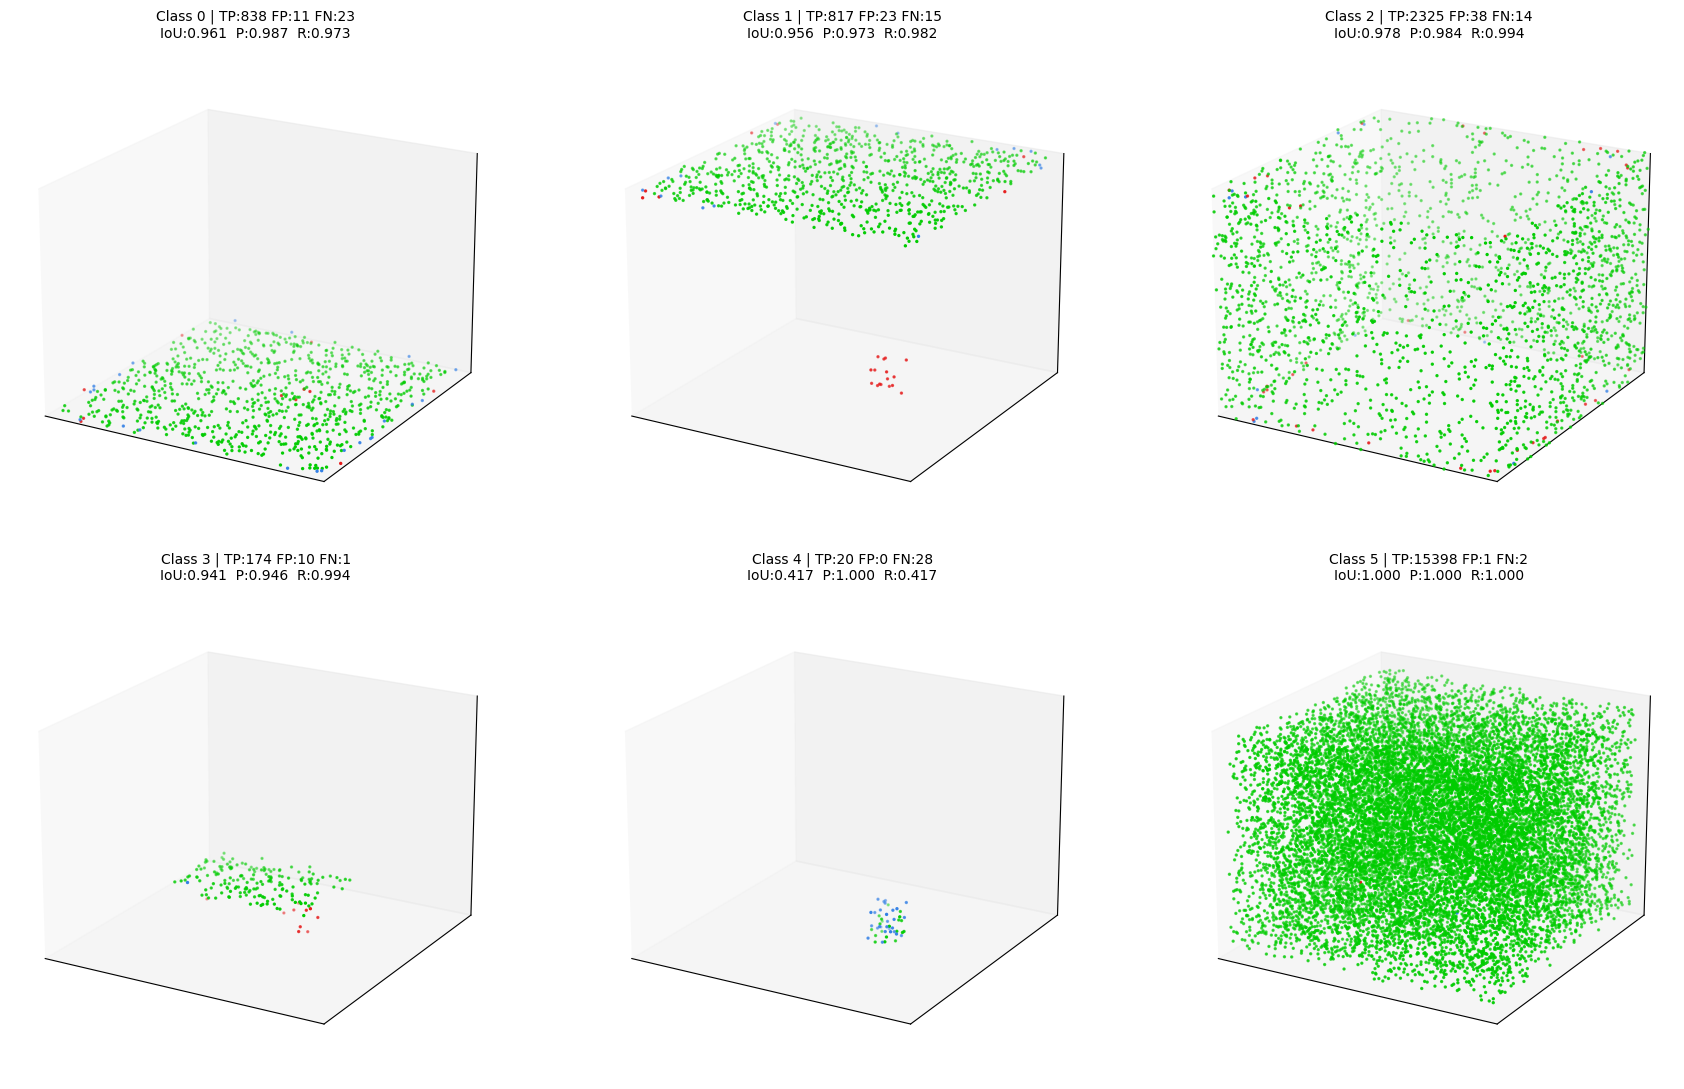

Visualized sample_index=8


In [23]:
#@title Per-class 3D visualization: GT vs Pred with TP/FP/FN
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import random

def _predict_voxel_labels_for_sample(sample, voxel_size, backend):
    """
    Return voxel centers, GT voxel labels, Pred voxel labels for a single sample.
    """
    pts, feats, labels = sample
    # Unpack all four values returned by voxelize_points
    c, f, y, inv = voxelize_points(pts, feats, labels, voxel_size)
    centers = (c.astype(np.float32) + 0.5) * voxel_size

    if backend == "ME":
        # Batch index column(0)을 붙여 SparseTensor 생성
        coords = torch.from_numpy(
            np.hstack([np.zeros((c.shape[0],1), dtype=np.int32), c.astype(np.int32)])
        ).int()  # CPU 유지
        feats_t = torch.from_numpy(f).float().to(device)
        with torch.no_grad():
            out = model(ME.SparseTensor(feats_t, coordinates=coords, device=device))
            y_pred = out.F.detach().cpu().argmax(dim=1).numpy()
    else:
        # Compact dense grid 구성
        min_c = c.min(0)
        c_off = c - min_c
        Dx, Dy, Dz = (c_off.max(0)+1).tolist()
        dense = torch.zeros((1, f.shape[1], Dx, Dy, Dz), dtype=torch.float32)
        mask  = torch.zeros((1, 1, Dx, Dy, Dz), dtype=torch.bool)
        x_t = torch.from_numpy(c_off[:,0]).long()
        y_t = torch.from_numpy(c_off[:,1]).long()
        z_t = torch.from_numpy(c_off[:,2]).long()
        dense[0, :, x_t, y_t, z_t] = torch.from_numpy(f).float().T
        mask[0, 0, x_t, y_t, z_t] = True
        with torch.no_grad():
            logits = model(dense.to(device), mask.to(device))
            pred_dense = logits.argmax(dim=1).cpu().numpy()[0]
        y_pred = pred_dense[c_off[:,0], c_off[:,1], c_off[:,2]]

    return centers, y.astype(np.int64), y_pred.astype(np.int64)

def _safe_metrics(tp, fp, fn):
    iou_den = tp + fp + fn
    iou = tp / iou_den if iou_den > 0 else float("nan")
    prec_den = tp + fp
    rec_den  = tp + fn
    prec = tp / prec_den if prec_den > 0 else float("nan")
    rec  = tp / rec_den  if rec_den  > 0 else float("nan")
    return iou, prec, rec

def visualize_per_class_gt_pred(dataset, voxel_size, backend, sample_index=None,
                                cols=3, max_points_per_class=20000, point_size=2,
                                elev=20, azim=-60, title_prefix="Class"):
    """
    For a single sample, show per-class TP/FP/FN 3D scatter subplots.
    """
    # 샘플 선택
    if sample_index is None:
        sample_index = random.randrange(len(dataset))
    sample = dataset[sample_index]
    centers, y_gt, y_pred = _predict_voxel_labels_for_sample(sample, voxel_size, backend)

    # 전체 범위(뷰포트 통일)
    xlim = (centers[:,0].min(), centers[:,0].max())
    ylim = (centers[:,1].min(), centers[:,1].max())
    zlim = (centers[:,2].min(), centers[:,2].max())

    rows = math.ceil(NUM_CLASSES / cols)
    fig = plt.figure(figsize=(6*cols, 5.5*rows))

    # 색상: TP 초록, FP 빨강, FN 파랑
    tp_col = np.array([0.0, 0.8, 0.0])
    fp_col = np.array([0.9, 0.1, 0.1])
    fn_col = np.array([0.2, 0.5, 0.9])

    for cls in range(NUM_CLASSES):
        ax = fig.add_subplot(rows, cols, cls+1, projection='3d')

        gt_mask   = (y_gt == cls)
        pred_mask = (y_pred == cls)
        tp = gt_mask & pred_mask
        fp = (~gt_mask) & pred_mask
        fn = gt_mask & (~pred_mask)

        # 표시할 인덱스(해당 클래스 관련된 점만)
        idx = np.where(tp | fp | fn)[0]

        # 과도한 점수면 서브샘플링
        if idx.size > max_points_per_class:
            sel = np.random.choice(idx, max_points_per_class, replace=False)
        else:
            sel = idx

        # 각 카테고리별 좌표
        tp_idx = np.intersect1d(sel, np.where(tp)[0], assume_unique=False)
        fp_idx = np.intersect1d(sel, np.where(fp)[0], assume_unique=False)
        fn_idx = np.intersect1d(sel, np.where(fn)[0], assume_unique=False)

        if tp_idx.size:
            ax.scatter(centers[tp_idx,0], centers[tp_idx,1], centers[tp_idx,2],
                       c=tp_col[None,:], s=point_size)
        if fp_idx.size:
            ax.scatter(centers[fp_idx,0], centers[fp_idx,1], centers[fp_idx,2],
                       c=fp_col[None,:], s=point_size)
        if fn_idx.size:
            ax.scatter(centers[fn_idx,0], centers[fn_idx,1], centers[fn_idx,2],
                       c=fn_col[None,:], s=point_size)

        # 메트릭
        tp_n, fp_n, fn_n = int(tp.sum()), int(fp.sum()), int(fn.sum())
        iou, prec, rec = _safe_metrics(tp_n, fp_n, fn_n)
        ax.set_title(f"{title_prefix} {cls} | TP:{tp_n} FP:{fp_n} FN:{fn_n}\nIoU:{0.0 if np.isnan(iou) else iou:.3f}  P:{0.0 if np.isnan(prec) else prec:.3f}  R:{0.0 if np.isnan(rec) else rec:.3f}",
                     fontsize=10)

        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_zlim(zlim)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

    plt.tight_layout()
    plt.show()
    print(f"Visualized sample_index={sample_index}")

# 사용 예시: 검증셋에서 랜덤 샘플
dataset_for_vis = val_ds if isinstance(val_ds, torch.utils.data.Subset) else val_ds
visualize_per_class_gt_pred(dataset_for_vis, VOXEL_SIZE, BACKEND, sample_index=None, cols=3, max_points_per_class=20000)

초록: TP(정답으로 맞춘 점)

빨강: FP(해당 클래스로 잘못 예측)

파랑: FN(해당 클래스인데 다른 클래스로 예측)

각 서브플롯 제목에 TP/FP/FN 개수와 IoU, Precision, Recall을 표시합니다.

## 사용자 데이터로 교체하기

In [ ]:
#@title BYOD skeleton
class YourPointCloudDataset(Dataset):
    def __init__(self, root, split="train"):
        super().__init__()
        self.items = []  # TODO: 파일 리스트 구성
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        # TODO: 파일 로드하여 다음 형식으로 반환
        # pts: (N,3) float32 in meters
        # feats: (N,C) float32 (e.g., RGB in [0,1])
        # labels: (N,) int64 in [0..NUM_CLASSES-1] or -1 to ignore
        raise NotImplementedError

# Example:
# ds = YourPointCloudDataset("/path/to/data", split="train")
# train_loader = make_loader(ds, VOXEL_SIZE, batch_size=BATCH_SIZE)

# Inference

In [16]:
#@title Paths and options
CKPT_PATH = "sscn_demo.pth"  # 학습된 체크포인트 경로
DEVICE_OVERRIDE = "cpu"         # 예: "cpu"로 강제, 기본은 자동 선택
MAX_POINTS_VIS = 60000       # 시각화 시 최대 표시 점 수(표시 성능 보호)

In [17]:
#@title Imports, device, voxelization
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_device():
    if DEVICE_OVERRIDE.strip():
        return torch.device(DEVICE_OVERRIDE.strip())
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

device = get_device()
print("Device:", device)

def voxelize_points(points, feats, labels_or_none, voxel_size: float):
    """
    points: (N,3) float32 in meters
    feats: (N,C) float32
    labels_or_none: None or (N,) int64
    returns:
      keys: (M,3) int32 voxel coords
      feats_agg: (M,C) float32 voxel-aggregated features
      labels_agg or None: (M,) int64 majority label
      inv: (N,) int per-point -> voxel index
    """
    coords = np.floor(points / voxel_size).astype(np.int64)
    keys, inv, counts = np.unique(coords, axis=0, return_inverse=True, return_counts=True)

    C = feats.shape[1]
    feats_sum = np.zeros((keys.shape[0], C), dtype=np.float64)
    np.add.at(feats_sum, inv, feats)
    feats_agg = (feats_sum / counts[:, None]).astype(np.float32)

    labels_agg = None
    if labels_or_none is not None:
        labels = labels_or_none
        labels_agg = np.zeros((keys.shape[0],), dtype=np.int64)
        for k in range(keys.shape[0]):
            m = (inv == k)
            lbls = labels[m]
            vals, freqs = np.unique(lbls, return_counts=True)
            labels_agg[k] = vals[np.argmax(freqs)]

    return keys.astype(np.int32), feats_agg, labels_agg, inv.astype(np.int64)

Device: cpu


In [18]:
#@title Models and checkpoint loading
import warnings

# Dense masked UNet (submanifold-like)
class MaskedSubMBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x, mask):
        x = self.relu(self.bn1(self.conv1(x))); x = x * mask
        x = self.relu(self.bn2(self.conv2(x))); x = x * mask
        return x

class DenseUNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=6):
        super().__init__()
        cs = [32, 64, 128, 256]
        self.enc1 = MaskedSubMBlock(in_ch, cs[0])
        self.down1 = nn.Conv3d(cs[0], cs[1], 2, stride=2)
        self.enc2 = MaskedSubMBlock(cs[1], cs[1])
        self.down2 = nn.Conv3d(cs[1], cs[2], 2, stride=2)
        self.enc3 = MaskedSubMBlock(cs[2], cs[2])
        self.down3 = nn.Conv3d(cs[2], cs[3], 2, stride=2)
        self.bott = MaskedSubMBlock(cs[3], cs[3])
        self.up3 = nn.ConvTranspose3d(cs[3], cs[2], 2, stride=2)
        self.dec3 = MaskedSubMBlock(cs[2]+cs[2], cs[2])
        self.up2 = nn.ConvTranspose3d(cs[2], cs[1], 2, stride=2)
        self.dec2 = MaskedSubMBlock(cs[1]+cs[1], cs[1])
        self.up1 = nn.ConvTranspose3d(cs[1], cs[0], 2, stride=2)
        self.dec1 = MaskedSubMBlock(cs[0]+cs[0], cs[0])
        self.classifier = nn.Conv3d(cs[0], out_ch, 1)

    @staticmethod
    def downsample_mask(mask):
        return F.max_pool3d(mask.float(), 2, stride=2).bool()

    @staticmethod
    def _align3d(x, ref_spatial):
        return x if x.shape[-3:] == ref_spatial else F.interpolate(x, size=ref_spatial, mode='trilinear', align_corners=False)

    def forward(self, x, mask):
        e1 = self.enc1(x, mask); m2 = self.downsample_mask(mask)
        e2 = self.enc2(self.down1(e1), m2); m3 = self.downsample_mask(m2)
        e3 = self.enc3(self.down2(e2), m3); m4 = self.downsample_mask(m3)
        b  = self.bott(self.down3(e3), m4)

        d3 = self.up3(b); d3 = self._align3d(d3, e3.shape[-3:]); d3 = self.dec3(torch.cat([d3, e3], 1), m3)
        d2 = self.up2(d3); d2 = self._align3d(d2, e2.shape[-3:]); d2 = self.dec2(torch.cat([d2, e2], 1), m2)
        d1 = self.up1(d2); d1 = self._align3d(d1, e1.shape[-3:]); d1 = self.dec1(torch.cat([d1, e1], 1), mask)
        return self.classifier(d1)

# ME UNet (선택적)
def _build_me_unet(num_classes):
    try:
        import MinkowskiEngine as ME
    except Exception as e:
        raise RuntimeError("Checkpoint requires BACKEND='ME' but MinkowskiEngine is not installed.") from e

    class ME_SubMBlock(nn.Module):
        def __init__(self, in_ch, out_ch, D=3):
            super().__init__()
            self.net = nn.Sequential(
                ME.MinkowskiSubmanifoldConvolution(in_ch, out_ch, kernel_size=3, dimension=D),
                ME.MinkowskiBatchNorm(out_ch),
                ME.MinkowskiReLU(inplace=True),
                ME.MinkowskiSubmanifoldConvolution(out_ch, out_ch, kernel_size=3, dimension=D),
                ME.MinkowskiBatchNorm(out_ch),
                ME.MinkowskiReLU(inplace=True),
            )
        def forward(self, x): return self.net(x)

    class ME_UNetSmall(nn.Module):
        def __init__(self, in_ch=3, out_ch=num_classes, D=3):
            super().__init__()
            self.ME = ME
            cs = [32, 64, 128, 256]
            self.enc1 = ME_SubMBlock(in_ch, cs[0], D)
            self.down1 = ME.MinkowskiConvolution(cs[0], cs[1], kernel_size=2, stride=2, dimension=D)
            self.enc2 = ME_SubMBlock(cs[1], cs[1], D)
            self.down2 = ME.MinkowskiConvolution(cs[1], cs[2], kernel_size=2, stride=2, dimension=D)
            self.enc3 = ME_SubMBlock(cs[2], cs[2], D)
            self.down3 = ME.MinkowskiConvolution(cs[2], cs[3], kernel_size=2, stride=2, dimension=D)
            self.bott = ME_SubMBlock(cs[3], cs[3], D)
            self.up3 = ME.MinkowskiConvolutionTranspose(cs[3], cs[2], kernel_size=2, stride=2, dimension=D)
            self.dec3 = ME_SubMBlock(cs[2]+cs[2], cs[2], D)
            self.up2 = ME.MinkowskiConvolutionTranspose(cs[2], cs[1], kernel_size=2, stride=2, dimension=D)
            self.dec2 = ME_SubMBlock(cs[1]+cs[1], cs[1], D)
            self.up1 = ME.MinkowskiConvolutionTranspose(cs[1], cs[0], kernel_size=2, stride=2, dimension=D)
            self.dec1 = ME_SubMBlock(cs[0]+cs[0], cs[0], D)
            self.classifier = ME.MinkowskiConvolution(cs[0], out_ch, kernel_size=1, stride=1, dimension=D)
        def forward(self, x):
            ME = self.ME
            e1 = self.enc1(x)
            e2 = self.enc2(self.down1(e1))
            e3 = self.enc3(self.down2(e2))
            b  = self.bott(self.down3(e3))
            d3 = self.up3(b); d3 = ME.cat(d3, e3); d3 = self.dec3(d3)
            d2 = self.up2(d3); d2 = ME.cat(d2, e2); d2 = self.dec2(d2)
            d1 = self.up1(d2); d1 = ME.cat(d1, e1); d1 = self.dec1(d1)
            return self.classifier(d1)

    return ME_UNetSmall

def load_sscn_checkpoint(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    backend = ckpt.get("backend", "DENSE")
    num_classes = int(ckpt.get("num_classes", 6))
    voxel_size = float(ckpt.get("voxel_size", 0.05))

    if backend == "DENSE":
        model = DenseUNetSmall(in_ch=3, out_ch=num_classes)
        model.load_state_dict(ckpt["state_dict"], strict=True)
        model.to(device).eval()
        return model, backend, num_classes, voxel_size
    elif backend == "ME":
        try:
            import MinkowskiEngine as ME
        except Exception as e:
            raise RuntimeError("This checkpoint was trained with BACKEND='ME'. Please install MinkowskiEngine to run inference.") from e
        ME_UNetSmall = _build_me_unet(num_classes)
        model = ME_UNetSmall(in_ch=3, out_ch=num_classes)
        model.load_state_dict(ckpt["state_dict"], strict=True)
        model.to(device).eval()
        return model, backend, num_classes, voxel_size
    else:
        raise ValueError(f"Unknown backend in checkpoint: {backend}")

model, BACKEND, NUM_CLASSES, VOXEL_SIZE = load_sscn_checkpoint(CKPT_PATH)
print(f"Loaded checkpoint: backend={BACKEND}, num_classes={NUM_CLASSES}, voxel_size={VOXEL_SIZE}")

Loaded checkpoint: backend=DENSE, num_classes=6, voxel_size=0.05


In [19]:
#@title Inference API: per-point prediction
@torch.no_grad()
def predict_points(points: np.ndarray, feats: np.ndarray, model, backend: str, voxel_size: float):
    """
    points: (N,3) float32 in meters
    feats:  (N,C) float32, C must match training input channels (here C=3 for RGB)
    returns:
      pred_point: (N,) int64 per-point predicted labels
      pred_voxel: (M,) int64 per-voxel labels
      inv: (N,) int per-point -> voxel index
      voxel_centers: (M,3) voxel centers in meters
    """
    if feats.ndim != 2:
        raise ValueError("feats must be 2D (N,C)")

    c, f, y_agg, inv = voxelize_points(points, feats, labels_or_none=None, voxel_size=voxel_size)
    centers = (c.astype(np.float32) + 0.5) * voxel_size

    if backend == "ME":
        import MinkowskiEngine as ME
        coords = torch.from_numpy(np.hstack([np.zeros((c.shape[0],1), dtype=np.int32), c.astype(np.int32)])).int()
        f_t = torch.from_numpy(f).float().to(device)                  # (M,C)
        st = ME.SparseTensor(f_t, coordinates=coords, device=device)  # single-batch sparse tensor
        out = model(st)                                               # sparse logits
        pred_voxel = out.F.detach().argmax(dim=1).cpu().numpy()
    else:
        # Build compact dense grid
        min_c = c.min(0)
        c_off = c - min_c
        Dx, Dy, Dz = (c_off.max(0)+1).tolist()
        dense = torch.zeros((1, f.shape[1], Dx, Dy, Dz), dtype=torch.float32)
        mask  = torch.zeros((1, 1, Dx, Dy, Dz), dtype=torch.bool)
        x_t = torch.from_numpy(c_off[:,0]).long()
        y_t = torch.from_numpy(c_off[:,1]).long()
        z_t = torch.from_numpy(c_off[:,2]).long()
        dense[0, :, x_t, y_t, z_t] = torch.from_numpy(f).float().T
        mask[0, 0, x_t, y_t, z_t] = True

        logits = model(dense.to(device), mask.to(device))
        pred_dense = logits.argmax(dim=1).cpu().numpy()[0]
        pred_voxel = pred_dense[c_off[:,0], c_off[:,1], c_off[:,2]]

    pred_point = pred_voxel[inv]
    return pred_point.astype(np.int64), pred_voxel.astype(np.int64), inv.astype(np.int64), centers

def evaluate_points(y_true: np.ndarray, y_pred: np.ndarray, num_classes: int):
    acc = float(np.mean(y_true == y_pred)) if len(y_true) else 0.0
    ious = []
    for i in range(num_classes):
        inter = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        ious.append(inter/union if union > 0 else np.nan)
    miou = float(np.nanmean(ious)) if np.any(~np.isnan(ious)) else 0.0
    return acc, ious, miou

In [20]:
#@title 3D visualization: GT vs Pred
label_colors = np.array([
    [160,160,160],  # 0
    [255,255,255],  # 1
    [220,220,220],  # 2
    [204,102, 26],  # 3
    [ 51,153,230],  # 4
    [ 30, 80,120],  # 5
], dtype=np.uint8)

def show_points_gt_pred(points, y_pred_point, y_true_point=None, elev=20, azim=-60, title_suffix=""):
    cols = label_colors if label_colors.shape[0] >= (y_pred_point.max()+1) else (np.random.rand(y_pred_point.max()+1,3)*255).astype(np.uint8)
    fig = plt.figure(figsize=(18,6))

    # Prediction
    ax2 = fig.add_subplot(132, projection='3d')
    c2 = cols[y_pred_point]/255.0
    sel = np.arange(min(len(points), MAX_POINTS_VIS))
    ax2.scatter(points[sel,0], points[sel,1], points[sel,2], c=c2[sel], s=1)
    ax2.set_title("Prediction"+title_suffix); ax2.view_init(elev=elev, azim=azim)

    if y_true_point is not None:
        # GT
        ax1 = fig.add_subplot(131, projection='3d')
        c1 = cols[y_true_point]/255.0
        ax1.scatter(points[sel,0], points[sel,1], points[sel,2], c=c1[sel], s=1)
        ax1.set_title("Ground Truth"); ax1.view_init(elev=elev, azim=azim)

        # Correctness
        ax3 = fig.add_subplot(133, projection='3d')
        correct = (y_true_point == y_pred_point)
        cr_cols = np.zeros((len(points), 3))
        cr_cols[correct] = np.array([0.0, 0.8, 0.0])
        cr_cols[~correct] = np.array([0.9, 0.1, 0.1])
        ax3.scatter(points[sel,0], points[sel,1], points[sel,2], c=cr_cols[sel], s=1)
        ax3.set_title("Correctness"); ax3.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()

Accuracy: 0.993, mIoU: 0.792
Per-class IoU: [0.9755147468002225, 0.949862258953168, 0.9729785478547854, 0.7690217391304348, 0.08888888888888889, 0.9969056050020736]


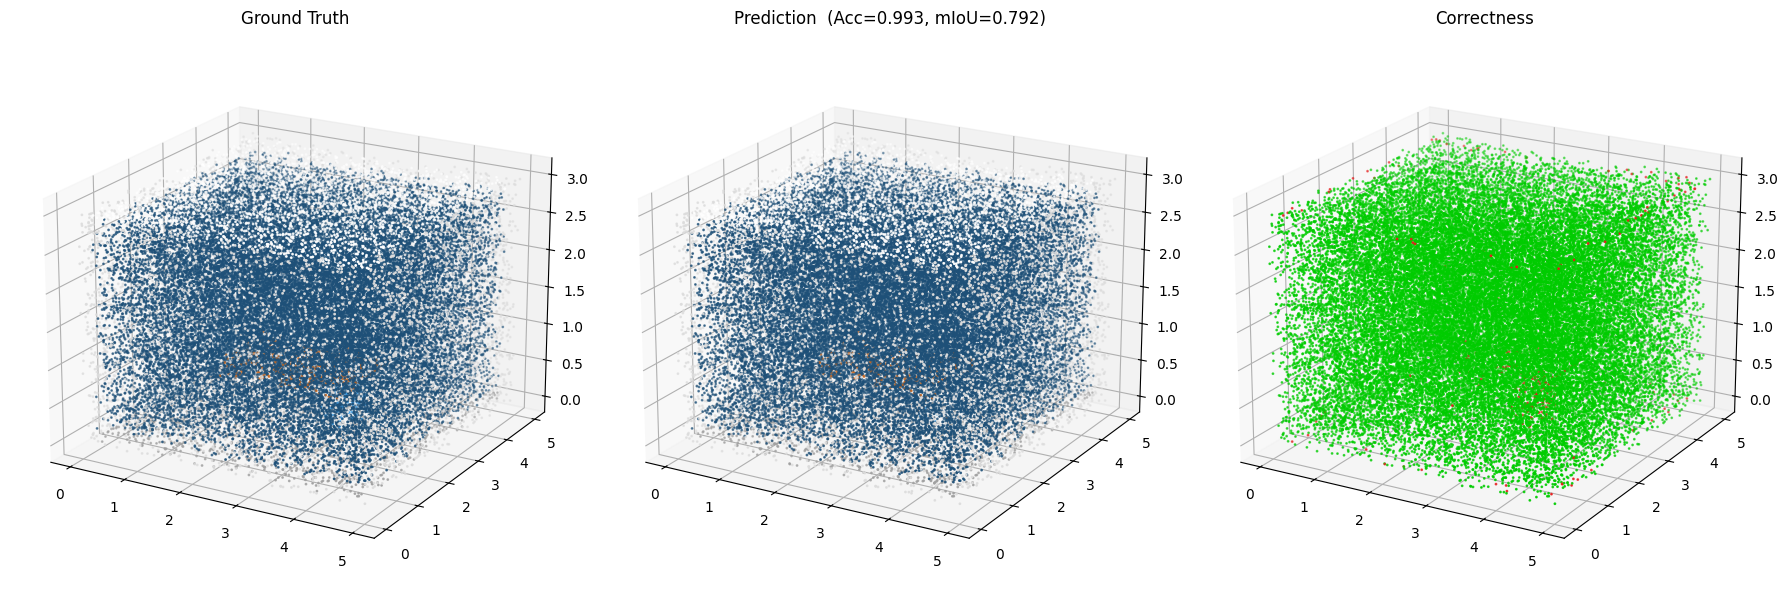

In [21]:
#@title Quick synthetic test (optional)
def make_synthetic_room(n_points=30000, seed=0):
    rng = np.random.RandomState(seed)
    pts = rng.rand(n_points, 3).astype(np.float32)
    pts[:,0] *= 5.0; pts[:,1] *= 5.0; pts[:,2] *= 3.0
    colors = np.zeros((n_points, 3), dtype=np.float32)
    labels = np.full((n_points,), 5, dtype=np.int64)

    floor = pts[:,2] < 0.15
    ceil  = pts[:,2] > 2.85
    wall  = (pts[:,0] < 0.15) | (pts[:,0] > 4.85) | (pts[:,1] < 0.15) | (pts[:,1] > 4.85)
    table = (np.abs(pts[:,0]-2.5)<1.2) & (np.abs(pts[:,1]-2.5)<0.8) & (np.abs(pts[:,2]-0.75)<0.1)
    chair = (np.abs(pts[:,0]-3.4)<0.3) & (np.abs(pts[:,1]-2.2)<0.3) & (np.abs(pts[:,2]-0.45)<0.25)

    labels[floor]=0; colors[floor]=[0.7,0.7,0.7]
    labels[ceil]=1;  colors[ceil]=[1.0,1.0,1.0]
    labels[wall]=2;  colors[wall]=[0.9,0.9,0.9]
    labels[table]=3; colors[table]=[0.8,0.4,0.1]
    labels[chair]=4; colors[chair]=[0.2,0.6,0.9]
    clutter = labels==5
    colors[clutter,0] = 0.1 + 0.6*(pts[clutter,2]/3.0); colors[clutter,1]=0.2; colors[clutter,2]=0.3

    order = rng.permutation(n_points)
    return pts[order], colors[order], labels[order]

# Create sample and run
pts, feats, y_true = make_synthetic_room(n_points=40000, seed=1)
y_pred_point, y_pred_voxel, inv, voxel_centers = predict_points(pts, feats, model, BACKEND, VOXEL_SIZE)
acc, ious, miou = evaluate_points(y_true, y_pred_point, NUM_CLASSES)
print(f"Accuracy: {acc:.3f}, mIoU: {miou:.3f}")
print("Per-class IoU:", [0.0 if np.isnan(v) else float(v) for v in ious])

show_points_gt_pred(pts, y_pred_point, y_true_point=y_true, title_suffix=f"  (Acc={acc:.3f}, mIoU={miou:.3f})")

In [ ]:
#@title Deployment helper: run on npz and save predictions
import os

def infer_npz(npz_path: str, out_path: str = None):
    data = np.load(npz_path)
    points = data["points"].astype(np.float32)   # (N,3)
    feats   = data["feats"].astype(np.float32)   # (N,C) e.g., C=3 (RGB in [0,1])
    labels  = data["labels"].astype(np.int64) if "labels" in data else None

    y_pred_point, y_pred_voxel, inv, voxel_centers = predict_points(points, feats, model, BACKEND, VOXEL_SIZE)
    if labels is not None:
        acc, ious, miou = evaluate_points(labels, y_pred_point, NUM_CLASSES)
        print(f"[{os.path.basename(npz_path)}] Accuracy={acc:.3f}, mIoU={miou:.3f}")

    if out_path is None:
        out_path = os.path.splitext(npz_path)[0] + "_pred.npz"
    np.savez_compressed(out_path,
                        points=points,
                        feats=feats,
                        pred=y_pred_point,
                        voxel_pred=y_pred_voxel,
                        inv=inv,
                        voxel_centers=voxel_centers)
    print(f"Saved predictions to {out_path}")
    return out_path

# 사용 예시:
# pred_file = infer_npz("sample_scene.npz")